In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import glob
import os

# POLOCM2 BASELINE acceptance rate

In [54]:


# Read and clean
p2_folder_path = "../../output/p2/"
csv_files = glob.glob(os.path.join(p2_folder_path, "*.csv"))
p2_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
p2_df = p2_df[p2_df['remark'] != 'Timeout']
p2_df.columns = p2_df.columns.str.strip()
p2_df['len%'] = p2_df['len%'].astype(float) * 100.0

p2b_folder_path = "../../output/p2b/"
csv_files = glob.glob(os.path.join(p2b_folder_path, "*.csv"))
p2b_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
p2b_df = p2b_df[p2b_df['remark'] != 'Timeout']
p2b_df.columns = p2b_df.columns.str.strip()
p2b_df['len%'] = p2b_df['len%'].astype(float) * 100.0

to_folder_path = "../../output/total/"
to_df = pd.read_csv(os.path.join(to_folder_path, "acceptance_rate.csv"))
to_df.columns = to_df.columns.str.strip()
to_df['len%'] = to_df['len%'].astype(float) * 100.0

flexs = [0.1, 0.4, 0.7]



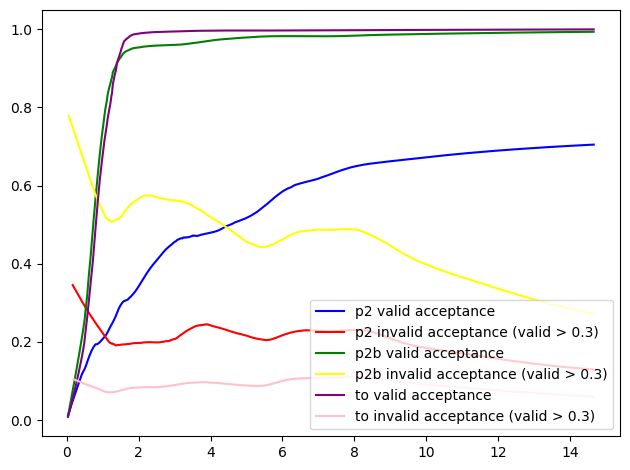

In [17]:
p2_df_len = p2_df.sort_values(by='len%')
p2b_df_len = p2b_df.sort_values(by='len%')
to_df_len = to_df.sort_values(by='len%')

# Apply LOWESS to full valid_exe
valid_smoothed_p2 = lowess(p2_df_len['acceptance_rate'], p2_df_len['len%'], frac=0.3)
filtered_df_p2 = p2_df_len[p2_df_len['acceptance_rate'] > 0.3]
invalid_smoothed_p2 = lowess(filtered_df_p2['invalid_acceptance_rate'], filtered_df_p2['len%'], frac=0.3)


valid_smoothed_p2b = lowess(p2b_df_len['acceptance_rate'], p2b_df_len['len%'], frac=0.3)
filtered_df_p2b = p2b_df_len[p2b_df_len['acceptance_rate'] > 0.3]
invalid_smoothed_p2b = lowess(filtered_df_p2b['invalid_acceptance_rate'], filtered_df_p2b['len%'], frac=0.3)

valid_smoothed_to = lowess(to_df_len['acceptance_rate'], to_df_len['len%'], frac=0.3)
filtered_df_to = to_df_len[to_df_len['acceptance_rate'] > 0.3]
invalid_smoothed_to = lowess(filtered_df_to['invalid_acceptance_rate'], filtered_df_to['len%'], frac=0.3)



plt.plot(valid_smoothed_p2[:, 0], valid_smoothed_p2[:, 1], label='p2 valid acceptance', color='blue')
plt.plot(invalid_smoothed_p2[:, 0], invalid_smoothed_p2[:, 1], label='p2 invalid acceptance (valid > 0.3)', color='red')

plt.plot(valid_smoothed_p2b[:, 0], valid_smoothed_p2b[:, 1], label='p2b valid acceptance', color='green')
plt.plot(invalid_smoothed_p2b[:, 0], invalid_smoothed_p2b[:, 1], label='p2b invalid acceptance (valid > 0.3)', color='yellow')

plt.plot(valid_smoothed_to[:, 0], valid_smoothed_to[:, 1], label='to valid acceptance', color='purple')
plt.plot(invalid_smoothed_to[:, 0], invalid_smoothed_to[:, 1], label='to invalid acceptance (valid > 0.3)', color='pink')


plt.legend()
plt.tight_layout()
plt.show()

# MEDIAN

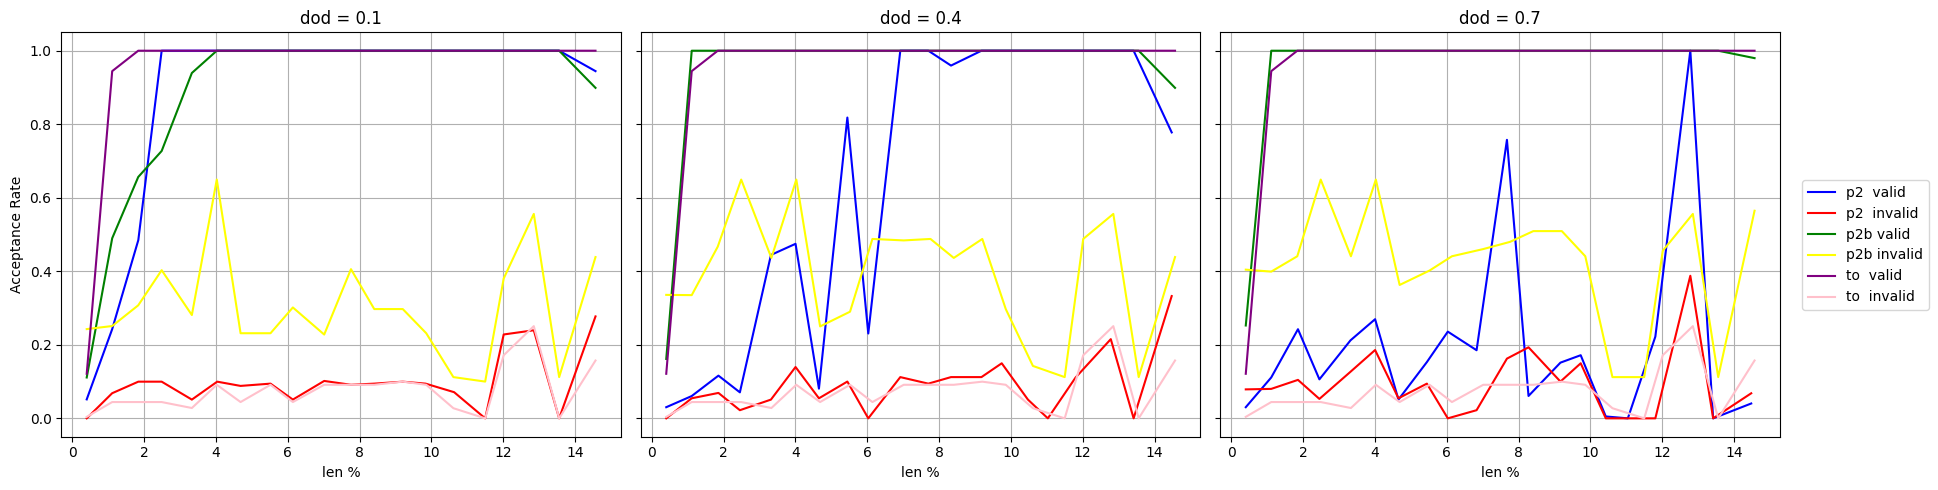

In [64]:
# Define a function to apply bin-based median smoothing
def smooth_by_binning(df, len_col='len%', valid_col='acceptance_rate', invalid_col='invalid_acceptance_rate', bins=20):
    df = df.copy()
    df['len_bin'] = pd.cut(df[len_col], bins=bins)
    
    grouped = df.groupby('len_bin', observed=True).agg({
        len_col: ['mean', 'median'],
        valid_col: ['mean', 'median'],
        invalid_col: ['mean', 'median']
    }).dropna().reset_index()
    
    # Flatten MultiIndex columns
    grouped.columns = ['len_bin', 'len_mean', 'len_median',
                       'valid_mean', 'valid_median',
                       'invalid_mean', 'invalid_median']
    
    return grouped

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(flexs),
    figsize=(6 * len(flexs), 5),
    sharey=True
)

for i, flex in enumerate(flexs):
    ax = axes[i]                        # current subplot

    # 1️⃣  filter & sort
    p2_df_len  = p2_df [p2_df ['dod'] == flex].sort_values('len%')
    p2b_df_len = p2b_df[p2b_df['dod'] == flex].sort_values('len%')
    to_df_len  = to_df.sort_values('len%')               # “to” has no flex filter

    # 2️⃣  bin-smoothing (median in each bin)
    p2_smooth  = smooth_by_binning(p2_df_len)
    p2b_smooth = smooth_by_binning(p2b_df_len)
    to_smooth  = smooth_by_binning(to_df_len)

    # 3️⃣  plot on this subplot
    ax.plot(p2_smooth ['len_median'],  p2_smooth ['valid_median'],   color='blue',   label='p2  valid')
    ax.plot(p2_smooth ['len_median'],  p2_smooth ['invalid_median'], color='red',    label='p2  invalid')

    ax.plot(p2b_smooth['len_median'],  p2b_smooth['valid_median'],   color='green',  label='p2b valid')
    ax.plot(p2b_smooth['len_median'],  p2b_smooth['invalid_median'], color='yellow', label='p2b invalid')

    ax.plot(to_smooth ['len_median'],  to_smooth ['valid_median'],   color='purple', label='to  valid')
    ax.plot(to_smooth ['len_median'],  to_smooth ['invalid_median'], color='pink',   label='to  invalid')

    ax.set_title(f"dod = {flex}")
    ax.set_xlabel("len %")
    if i == 0:                          # only left-most subplot needs y-label
        ax.set_ylabel("Acceptance Rate")
    ax.grid(True)

# 4️⃣  put a single legend outside the plot grid
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="center left",
           bbox_to_anchor=(1.0, 0.5))  # to the right of the last subplot

plt.tight_layout(rect=[0, 0, 1, 1])   # leave room on the right for the legend
plt.show()

# MEAN

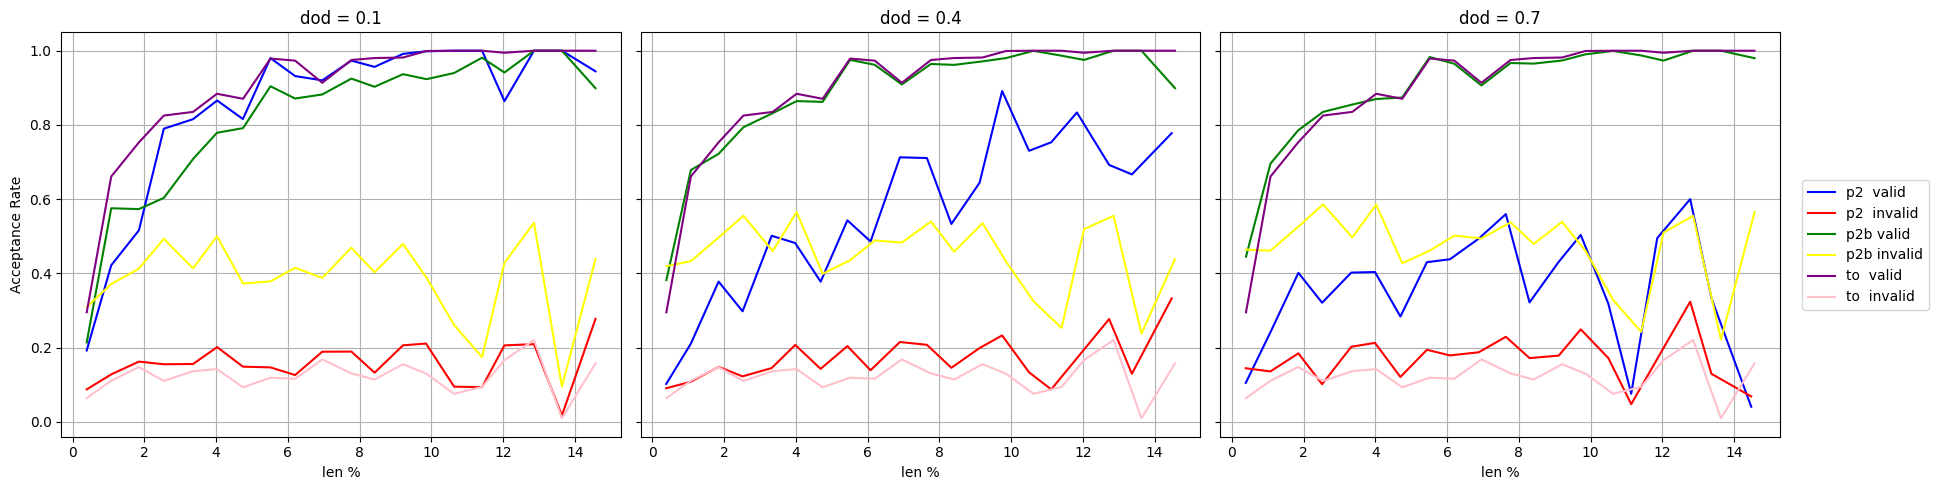

In [65]:




fig, axes = plt.subplots(
    nrows=1,
    ncols=len(flexs),
    figsize=(6 * len(flexs), 5),
    sharey=True
)

for i, flex in enumerate(flexs):
    ax = axes[i]                        # current subplot

    # 1️⃣  filter & sort
    p2_df_len  = p2_df [p2_df ['dod'] == flex].sort_values('len%')
    p2b_df_len = p2b_df[p2b_df['dod'] == flex].sort_values('len%')
    to_df_len  = to_df.sort_values('len%')               # “to” has no flex filter

    # 2️⃣  bin-smoothing (median in each bin)
    p2_smooth  = smooth_by_binning(p2_df_len)
    p2b_smooth = smooth_by_binning(p2b_df_len)
    to_smooth  = smooth_by_binning(to_df_len)

    # 3️⃣  plot on this subplot
    ax.plot(p2_smooth ['len_mean'],  p2_smooth ['valid_mean'],   color='blue',   label='p2  valid')
    ax.plot(p2_smooth ['len_mean'],  p2_smooth ['invalid_mean'], color='red',    label='p2  invalid')

    ax.plot(p2b_smooth['len_mean'],  p2b_smooth['valid_mean'],   color='green',  label='p2b valid')
    ax.plot(p2b_smooth['len_mean'],  p2b_smooth['invalid_mean'], color='yellow', label='p2b invalid')

    ax.plot(to_smooth ['len_mean'],  to_smooth ['valid_mean'],   color='purple', label='to  valid')
    ax.plot(to_smooth ['len_mean'],  to_smooth ['invalid_mean'], color='pink',   label='to  invalid')

    ax.set_title(f"dod = {flex}")
    ax.set_xlabel("len %")
    if i == 0:                          # only left-most subplot needs y-label
        ax.set_ylabel("Acceptance Rate")
    ax.grid(True)

# 4️⃣  put a single legend outside the plot grid
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="center left",
           bbox_to_anchor=(1.0, 0.5))  # to the right of the last subplot

plt.tight_layout(rect=[0, 0, 1, 1])   # leave room on the right for the legend
plt.show()


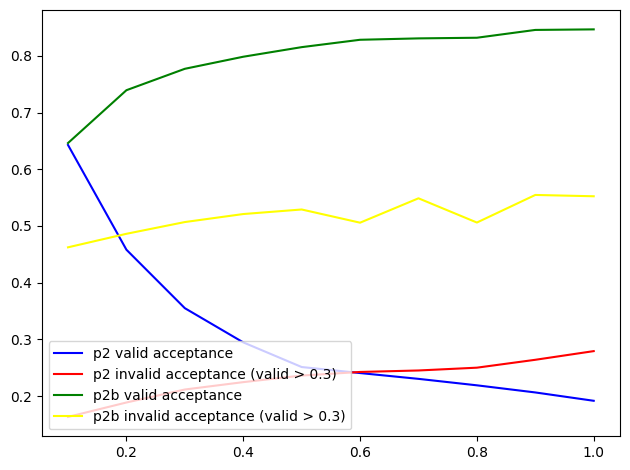

In [20]:
p2_df_flex = p2_df.sort_values(by='dod')
p2b_df_flex = p2b_df.sort_values(by='dod')


# Apply LOWESS to full valid_exe
valid_smoothed_p2 = lowess(p2_df_flex['acceptance_rate'], p2_df_flex['dod'], frac=0.3)
filtered_df_p2 = p2_df_flex[p2_df_flex['acceptance_rate'] > 0.3]
invalid_smoothed_p2 = lowess(filtered_df_p2['invalid_acceptance_rate'], filtered_df_p2['dod'], frac=0.3)


valid_smoothed_p2b = lowess(p2b_df_flex['acceptance_rate'], p2b_df_flex['dod'], frac=0.3)
filtered_df_p2b = p2b_df_flex[p2b_df_flex['acceptance_rate'] > 0.3]
invalid_smoothed_p2b = lowess(filtered_df_p2b['invalid_acceptance_rate'], filtered_df_p2b['dod'], frac=0.3)




plt.plot(valid_smoothed_p2[:, 0], valid_smoothed_p2[:, 1], label='p2 valid acceptance', color='blue')
plt.plot(invalid_smoothed_p2[:, 0], invalid_smoothed_p2[:, 1], label='p2 invalid acceptance (valid > 0.3)', color='red')

plt.plot(valid_smoothed_p2b[:, 0], valid_smoothed_p2b[:, 1], label='p2b valid acceptance', color='green')
plt.plot(invalid_smoothed_p2b[:, 0], invalid_smoothed_p2b[:, 1], label='p2b invalid acceptance (valid > 0.3)', color='yellow')




plt.legend()
plt.tight_layout()
plt.show()

# Accuracy and Error rate

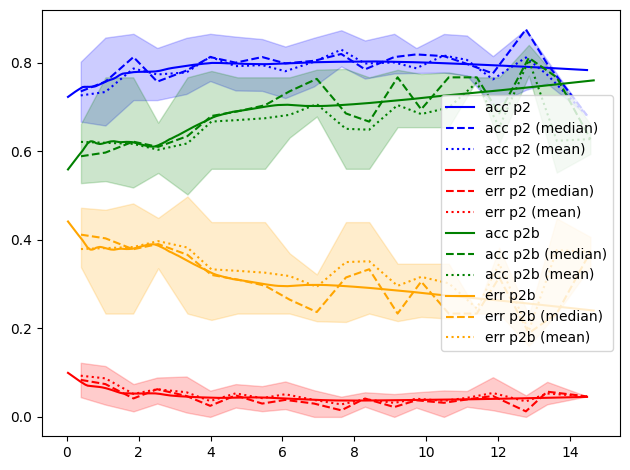

In [38]:
import numpy as np
def compute_percentile_band(df, x_col, y_col, bins=20):
    df = df.copy()
    df['len_bin'] = pd.cut(df[x_col], bins=bins)
    grouped = df.groupby('len_bin', observed=True).agg(
        len_mid=(x_col, 'mean'),
        p25=(y_col, lambda x: np.percentile(x, 25)),
        p50=(y_col, 'median'),
        mean=(y_col, 'mean'),
        p75=(y_col, lambda x: np.percentile(x, 75))
    ).dropna().reset_index()
    return grouped


band_acc_p2 = compute_percentile_band(p2_df_len, 'len%', 'accuracy')
band_err_p2 = compute_percentile_band(p2_df_len, 'len%', 'error_rate')

band_acc_p2b = compute_percentile_band(p2b_df_len, 'len%', 'accuracy')
band_err_p2b = compute_percentile_band(p2b_df_len, 'len%', 'error_rate')

acc_p2 = lowess(p2_df_len['accuracy'], p2_df_len['len%'], frac=0.3)
err_p2 = lowess(p2_df_len['error_rate'], p2_df_len['len%'], frac=0.3)

acc_p2b = lowess(p2b_df_len['accuracy'], p2b_df_len['len%'], frac=0.3)
err_p2b = lowess(p2b_df_len['error_rate'], p2b_df_len['len%'], frac=0.3)

plt.plot(acc_p2[:, 0], acc_p2[:, 1], label='acc p2', color='blue')
plt.fill_between(band_acc_p2['len_mid'], band_acc_p2['p25'], band_acc_p2['p75'], color='blue', alpha=0.2)
plt.plot(band_acc_p2['len_mid'], band_acc_p2['p50'], label='acc p2 (median)', color='blue', linestyle='--')
plt.plot(band_acc_p2['len_mid'], band_acc_p2['mean'], label='acc p2 (mean)', color='blue', linestyle=':')


plt.plot(err_p2[:, 0], err_p2[:, 1], label='err p2', color='red')
plt.fill_between(band_err_p2['len_mid'], band_err_p2['p25'], band_err_p2['p75'], color='red', alpha=0.2)
plt.plot(band_err_p2['len_mid'], band_err_p2['p50'], label='err p2 (median)', color='red', linestyle='--')
plt.plot(band_err_p2['len_mid'], band_err_p2['mean'], label='err p2 (mean)', color='red', linestyle=':')


plt.plot(acc_p2b[:, 0], acc_p2b[:, 1], label='acc p2b', color='green')
plt.fill_between(band_acc_p2b['len_mid'], band_acc_p2b['p25'], band_acc_p2b['p75'], color='green', alpha=0.2)
plt.plot(band_acc_p2b['len_mid'], band_acc_p2b['p50'], label='acc p2b (median)', color='green', linestyle='--')
plt.plot(band_acc_p2b['len_mid'], band_acc_p2b['mean'], label='acc p2b (mean)', color='green', linestyle=':')


plt.plot(err_p2b[:, 0], err_p2b[:, 1], label='err p2b', color='orange')
plt.fill_between(band_err_p2b['len_mid'], band_err_p2b['p25'], band_err_p2b['p75'], color='orange', alpha=0.2)
plt.plot(band_err_p2b['len_mid'], band_err_p2b['p50'], label='err p2b (median)', color='orange', linestyle='--')
plt.plot(band_err_p2b['len_mid'], band_err_p2b['mean'], label='err p2b (mean)', color='orange', linestyle=':')


# Combine into dataframe for seaborn


plt.legend()
plt.tight_layout()
plt.show()



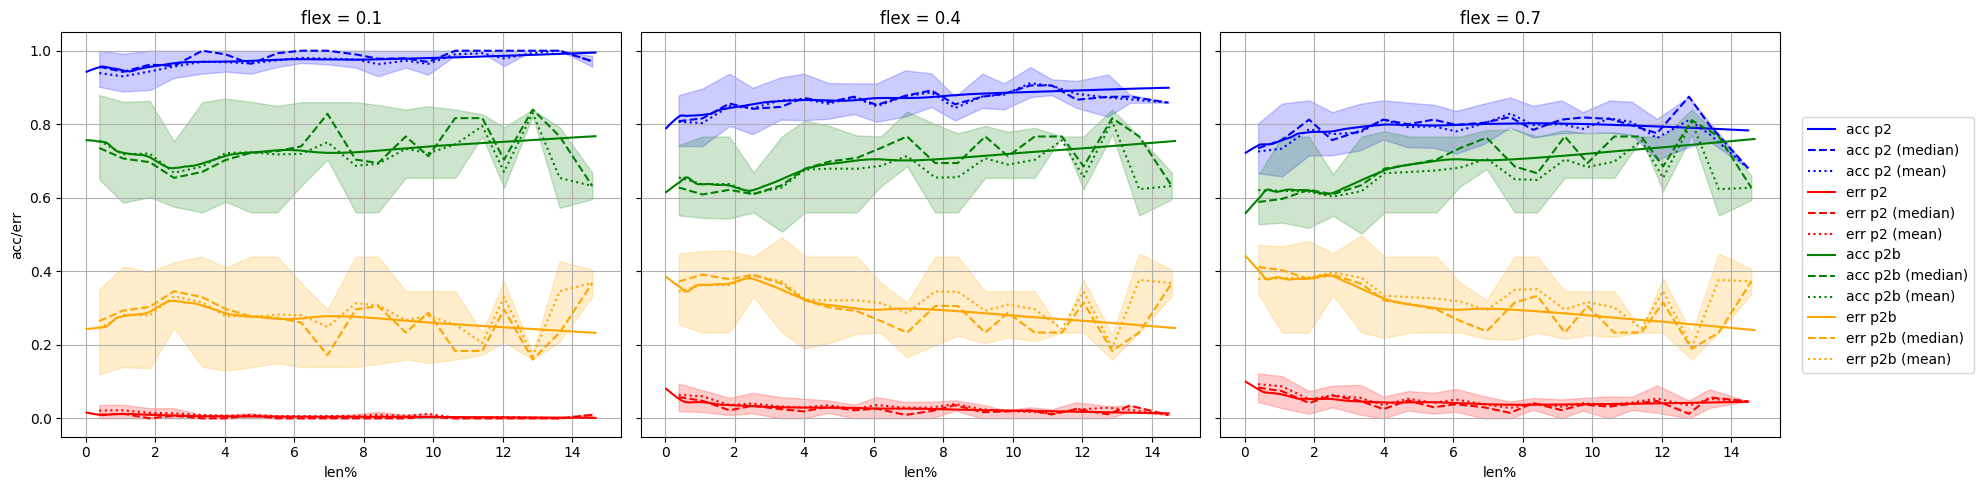

In [53]:
dods = [0.1, 0.4, 0.7]
fig, axes = plt.subplots(1, len(dods), figsize=(18, 5), sharey=True)

for i, dod in enumerate(dods):
    ax = axes[i]
    p2_df_len = p2_df[p2_df['dod'] == dod].sort_values(by='len%')
    p2b_df_len = p2b_df[p2b_df['dod'] == dod].sort_values(by='len%')

    band_acc_p2 = compute_percentile_band(p2_df_len, 'len%', 'accuracy')
    band_err_p2 = compute_percentile_band(p2_df_len, 'len%', 'error_rate')
    band_acc_p2b = compute_percentile_band(p2b_df_len, 'len%', 'accuracy')
    band_err_p2b = compute_percentile_band(p2b_df_len, 'len%', 'error_rate')

    acc_p2 = lowess(p2_df_len['accuracy'], p2_df_len['len%'], frac=0.3)
    err_p2 = lowess(p2_df_len['error_rate'], p2_df_len['len%'], frac=0.3)
    acc_p2b = lowess(p2b_df_len['accuracy'], p2b_df_len['len%'], frac=0.3)
    err_p2b = lowess(p2b_df_len['error_rate'], p2b_df_len['len%'], frac=0.3)

    ax.plot(acc_p2[:, 0], acc_p2[:, 1], label='acc p2', color='blue')
    ax.fill_between(band_acc_p2['len_mid'], band_acc_p2['p25'], band_acc_p2['p75'], color='blue', alpha=0.2)
    ax.plot(band_acc_p2['len_mid'], band_acc_p2['p50'], label='acc p2 (median)', color='blue', linestyle='--')
    ax.plot(band_acc_p2['len_mid'], band_acc_p2['mean'], label='acc p2 (mean)', color='blue', linestyle=':')

    ax.plot(err_p2[:, 0], err_p2[:, 1], label='err p2', color='red')
    ax.fill_between(band_err_p2['len_mid'], band_err_p2['p25'], band_err_p2['p75'], color='red', alpha=0.2)
    ax.plot(band_err_p2['len_mid'], band_err_p2['p50'], label='err p2 (median)', color='red', linestyle='--')
    ax.plot(band_err_p2['len_mid'], band_err_p2['mean'], label='err p2 (mean)', color='red', linestyle=':')

    ax.plot(acc_p2b[:, 0], acc_p2b[:, 1], label='acc p2b', color='green')
    ax.fill_between(band_acc_p2b['len_mid'], band_acc_p2b['p25'], band_acc_p2b['p75'], color='green', alpha=0.2)
    ax.plot(band_acc_p2b['len_mid'], band_acc_p2b['p50'], label='acc p2b (median)', color='green', linestyle='--')
    ax.plot(band_acc_p2b['len_mid'], band_acc_p2b['mean'], label='acc p2b (mean)', color='green', linestyle=':')

    ax.plot(err_p2b[:, 0], err_p2b[:, 1], label='err p2b', color='orange')
    ax.fill_between(band_err_p2b['len_mid'], band_err_p2b['p25'], band_err_p2b['p75'], color='orange', alpha=0.2)
    ax.plot(band_err_p2b['len_mid'], band_err_p2b['p50'], label='err p2b (median)', color='orange', linestyle='--')
    ax.plot(band_err_p2b['len_mid'], band_err_p2b['mean'], label='err p2b (mean)', color='orange', linestyle=':')

    ax.set_title(f'flex = {dod}')
    ax.set_xlabel('len%')
    if i == 0:
        ax.set_ylabel('acc/err')
    ax.grid(True)

# Only show legend on the last subplot
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()  # shrink main area to leave space on right
plt.show()

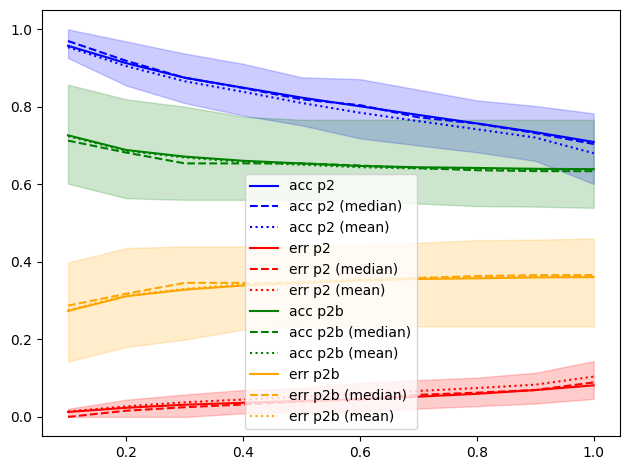

In [28]:
def compute_percentiles_discrete(df, x_col, y_col):
    grouped = df.groupby(x_col).agg(
        p25=(y_col, lambda x: np.percentile(x, 25)),
        p50=(y_col, 'median'),
        mean = (y_col, 'mean'),
        p75=(y_col, lambda x: np.percentile(x, 75))
    ).reset_index()
    grouped = grouped.rename(columns={x_col: 'x'})
    return grouped

band_acc_p2 = compute_percentiles_discrete(p2_df_flex, 'dod', 'accuracy')
band_err_p2 = compute_percentiles_discrete(p2_df_flex, 'dod', 'error_rate')

band_acc_p2b = compute_percentiles_discrete(p2b_df_flex, 'dod', 'accuracy')
band_err_p2b = compute_percentiles_discrete(p2b_df_flex, 'dod', 'error_rate')


acc_p2 = lowess(p2_df_flex['accuracy'], p2_df_flex['dod'], frac=0.3)
err_p2 = lowess(p2_df_flex['error_rate'], p2_df_flex['dod'], frac=0.3)

acc_p2b = lowess(p2b_df_flex['accuracy'], p2b_df_flex['dod'], frac=0.3)
err_p2b = lowess(p2b_df_flex['error_rate'], p2b_df_flex['dod'], frac=0.3)

# Combine into dataframe for seaborn



plt.plot(acc_p2[:, 0], acc_p2[:, 1], label='acc p2', color='blue')
plt.fill_between(band_acc_p2['x'], band_acc_p2['p25'], band_acc_p2['p75'], color='blue', alpha=0.2)
plt.plot(band_acc_p2['x'], band_acc_p2['p50'], label='acc p2 (median)', color='blue', linestyle='--')
plt.plot(band_acc_p2['x'], band_acc_p2['mean'], label='acc p2 (mean)', color='blue', linestyle=':')


plt.plot(err_p2[:, 0], err_p2[:, 1], label='err p2', color='red')
plt.fill_between(band_err_p2['x'], band_err_p2['p25'], band_err_p2['p75'], color='red', alpha=0.2)
plt.plot(band_err_p2['x'], band_err_p2['p50'], label='err p2 (median)', color='red', linestyle='--')
plt.plot(band_err_p2['x'], band_err_p2['mean'], label='err p2 (mean)', color='red', linestyle=':')


plt.plot(acc_p2b[:, 0], acc_p2b[:, 1], label='acc p2b', color='green')
plt.fill_between(band_acc_p2b['x'], band_acc_p2b['p25'], band_acc_p2b['p75'], color='green', alpha=0.2)
plt.plot(band_acc_p2b['x'], band_acc_p2b['p50'], label='acc p2b (median)', color='green', linestyle='--')
plt.plot(band_acc_p2b['x'], band_acc_p2b['mean'], label='acc p2b (mean)', color='green', linestyle=':')


plt.plot(err_p2b[:, 0], err_p2b[:, 1], label='err p2b', color='orange')
plt.fill_between(band_err_p2b['x'], band_err_p2b['p25'], band_err_p2b['p75'], color='orange', alpha=0.2)
plt.plot(band_err_p2b['x'], band_err_p2b['p50'], label='err p2b (median)', color='orange', linestyle='--')
plt.plot(band_err_p2b['x'], band_err_p2b['mean'], label='err p2b (mean)', color='orange', linestyle=':')


plt.legend()
plt.tight_layout()
plt.show()

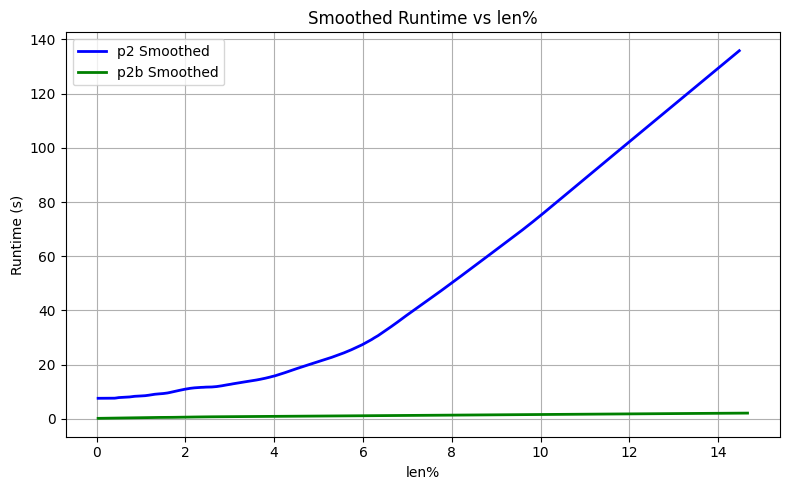

In [71]:


smoothed_p2 = lowess(p2_df_len['runtime'], p2_df_len['len%'], frac=0.3)  # Adjust frac for smoothing level
smoothed_p2b = lowess(p2b_df_len['runtime'], p2b_df_len['len%'], frac=0.3)  # Adjust frac for smoothing level

# Plot
plt.figure(figsize=(8, 5))

plt.plot(smoothed_p2[:, 0], smoothed_p2[:, 1], '-', linewidth=2, label='p2 Smoothed', color='blue')
plt.plot(smoothed_p2b[:, 0], smoothed_p2b[:, 1], '-', linewidth=2, label='p2b Smoothed', color='green')
plt.xlabel('len%')
plt.ylabel('Runtime (s)')
plt.title('Smoothed Runtime vs len%')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

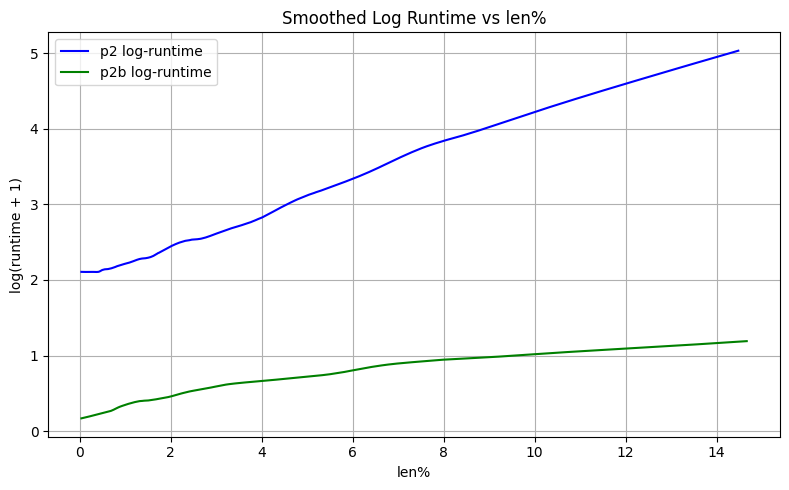

In [69]:
p2_df_len['log_runtime'] = np.log1p(p2_df_len['runtime'])
p2b_df_len['log_runtime'] = np.log1p(p2b_df_len['runtime'])

# LOWESS on log-runtime
smoothed_p2 = lowess(p2_df_len['log_runtime'], p2_df_len['len%'], frac=0.3)
smoothed_p2b = lowess(p2b_df_len['log_runtime'], p2b_df_len['len%'], frac=0.3)

# Plot log-runtime directly
plt.figure(figsize=(8, 5))
plt.plot(smoothed_p2[:, 0], smoothed_p2[:, 1], label='p2 log-runtime', color='blue')
plt.plot(smoothed_p2b[:, 0], smoothed_p2b[:, 1], label='p2b log-runtime', color='green')
plt.xlabel('len%')
plt.ylabel('log(runtime + 1)')
plt.title('Smoothed Log Runtime vs len%')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


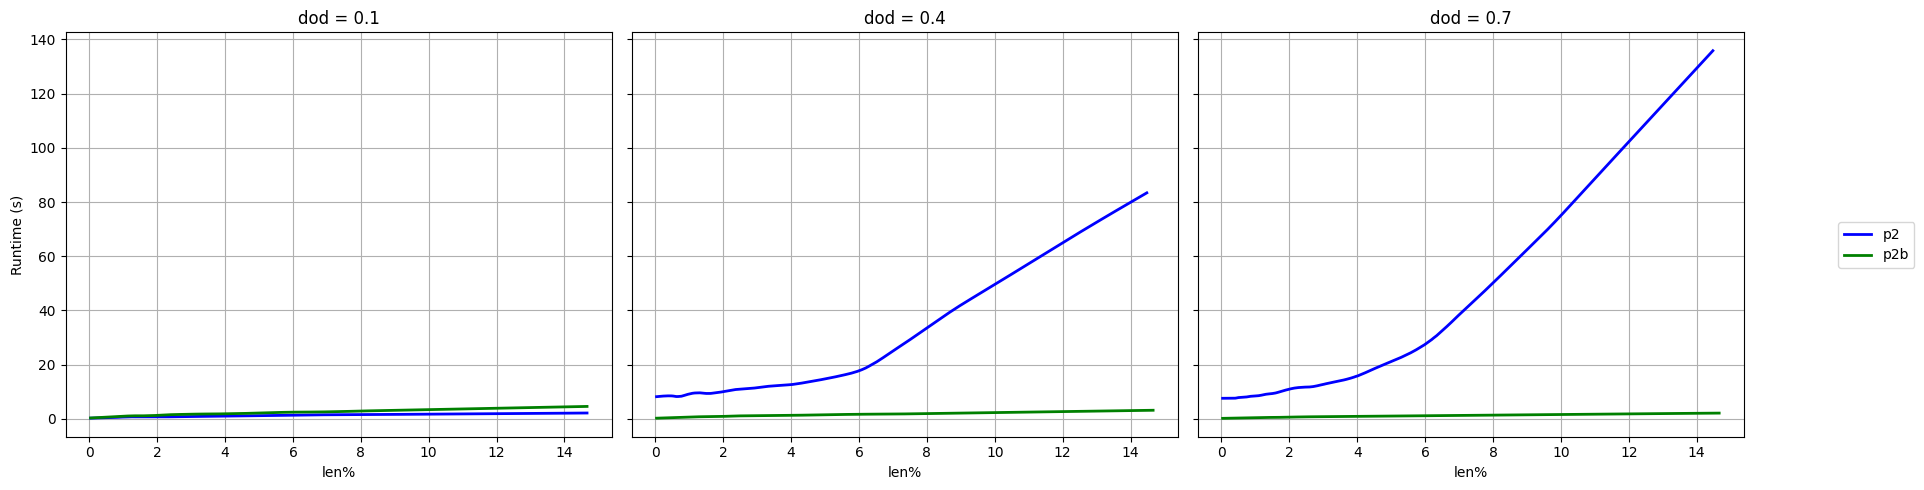

In [67]:
fig, axes = plt.subplots(1, len(flexs), figsize=(6 * len(flexs), 5), sharey=True)

for i, flex in enumerate(flexs):
    ax = axes[i]

    # Filter and sort
    p2_df_len = p2_df[p2_df['dod'] == flex].sort_values('len%')
    p2b_df_len = p2b_df[p2b_df['dod'] == flex].sort_values('len%')

    # LOWESS smoothing
    smoothed_p2 = lowess(p2_df_len['runtime'], p2_df_len['len%'], frac=0.3)
    smoothed_p2b = lowess(p2b_df_len['runtime'], p2b_df_len['len%'], frac=0.3)

    # Plot in current subplot
    ax.plot(smoothed_p2[:, 0], smoothed_p2[:, 1], '-', linewidth=2, label='p2', color='blue')
    ax.plot(smoothed_p2b[:, 0], smoothed_p2b[:, 1], '-', linewidth=2, label='p2b', color='green')

    ax.set_title(f'dod = {flex}')
    ax.set_xlabel('len%')
    if i == 0:
        ax.set_ylabel('Runtime (s)')
    ax.grid(True)

# Add legend outside the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout(rect=[0, 0, 0.98, 1])  # Leave space on the right for legend
plt.show()

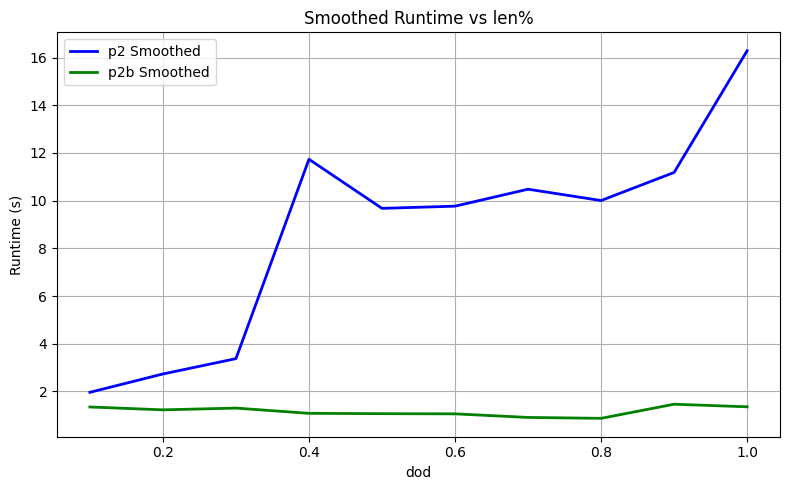

In [24]:
smoothed_p2 = lowess(p2_df_flex['runtime'], p2_df_flex['dod'], frac=0.3)  # Adjust frac for smoothing level
smoothed_p2b = lowess(p2b_df_flex['runtime'], p2b_df_flex['dod'], frac=0.3)  # Adjust frac for smoothing level

# Plot
plt.figure(figsize=(8, 5))

plt.plot(smoothed_p2[:, 0], smoothed_p2[:, 1], '-', linewidth=2, label='p2 Smoothed', color='blue')
plt.plot(smoothed_p2b[:, 0], smoothed_p2b[:, 1], '-', linewidth=2, label='p2b Smoothed', color='green')
plt.xlabel('dod')
plt.ylabel('Runtime (s)')
plt.title('Smoothed Runtime vs len%')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

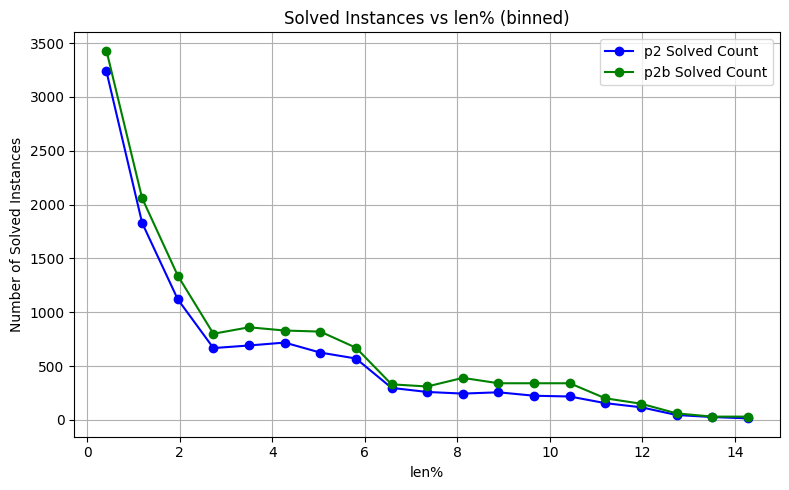

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define bins (e.g., 20 equal-width bins)
bins = np.linspace(p2_df_len['len%'].min(), p2_df_len['len%'].max(), 20)

# Step 2: Bin the data
p2_df_len['len_bin'] = pd.cut(p2_df_len['len%'], bins)
p2b_df_len['len_bin'] = pd.cut(p2b_df_len['len%'], bins)

# Step 3: Count number of entries per bin
p2_counts = p2_df_len['len_bin'].value_counts(sort=False).sort_index().reset_index()
p2b_counts = p2b_df_len['len_bin'].value_counts(sort=False).sort_index().reset_index()

# Step 4: Rename columns
p2_counts.columns = ['bin', 'count']
p2b_counts.columns = ['bin', 'count']

# Step 5: Compute bin centers for plotting
p2_counts['bin_center'] = p2_counts['bin'].apply(lambda x: x.mid)
p2b_counts['bin_center'] = p2b_counts['bin'].apply(lambda x: x.mid)

plt.figure(figsize=(8, 5))
plt.plot(p2_counts['bin_center'], p2_counts['count'], label='p2 Solved Count', marker='o', color='blue')
plt.plot(p2b_counts['bin_center'], p2b_counts['count'], label='p2b Solved Count', marker='o', color='green')
plt.xlabel('len%')
plt.ylabel('Number of Solved Instances')
plt.title('Solved Instances vs len% (binned)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


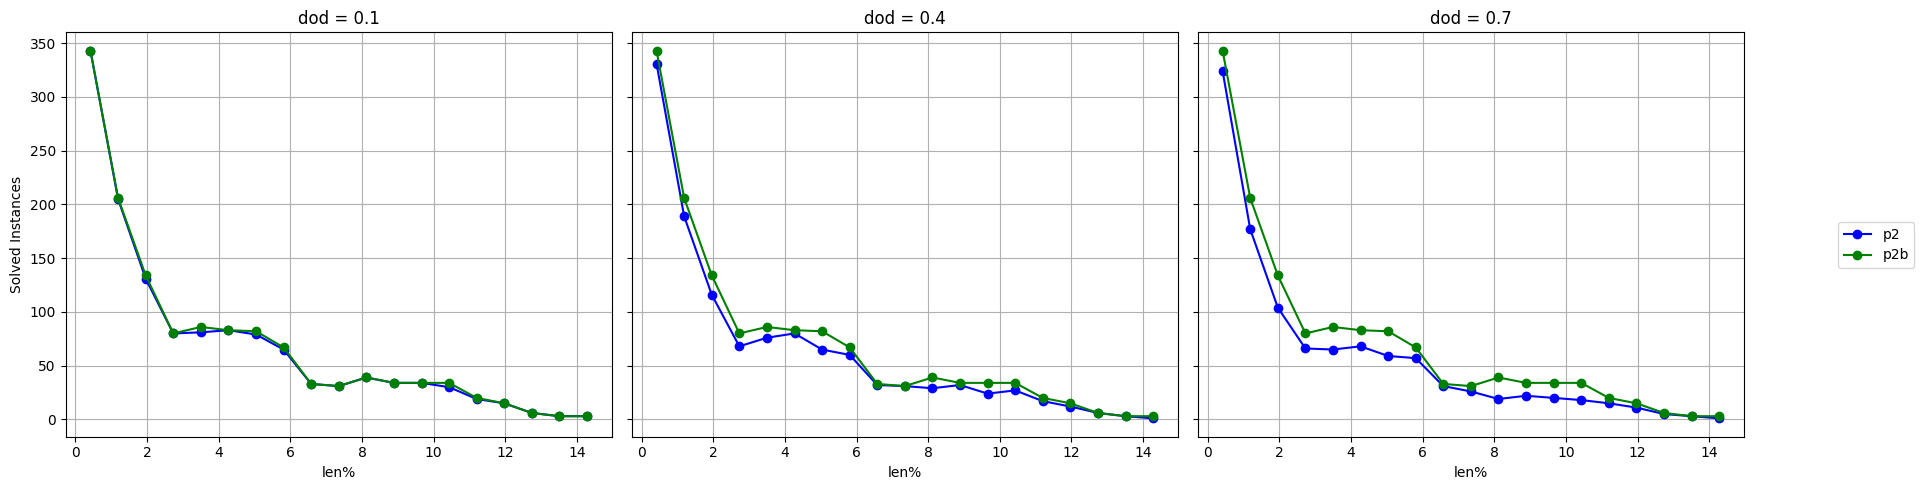

In [66]:
fig, axes = plt.subplots(1, len(flexs), figsize=(6 * len(flexs), 5), sharey=True)

for i, flex in enumerate(flexs):
    ax = axes[i]

    # Filter and sort
    p2_df_len = p2_df[p2_df['dod'] == flex].sort_values('len%')
    p2b_df_len = p2b_df[p2b_df['dod'] == flex].sort_values('len%')

    # Define common bins for this flex
    bins = np.linspace(
        min(p2_df_len['len%'].min(), p2b_df_len['len%'].min()),
        max(p2_df_len['len%'].max(), p2b_df_len['len%'].max()),
        20
    )

    # Bin and count
    p2_df_len['len_bin'] = pd.cut(p2_df_len['len%'], bins)
    p2b_df_len['len_bin'] = pd.cut(p2b_df_len['len%'], bins)

    p2_counts = p2_df_len['len_bin'].value_counts(sort=False).sort_index().reset_index()
    p2b_counts = p2b_df_len['len_bin'].value_counts(sort=False).sort_index().reset_index()

    p2_counts.columns = ['bin', 'count']
    p2b_counts.columns = ['bin', 'count']

    # Compute bin centers
    p2_counts['bin_center'] = p2_counts['bin'].apply(lambda x: x.mid)
    p2b_counts['bin_center'] = p2b_counts['bin'].apply(lambda x: x.mid)

    # Plot
    ax.plot(p2_counts['bin_center'], p2_counts['count'], label='p2', marker='o', color='blue')
    ax.plot(p2b_counts['bin_center'], p2b_counts['count'], label='p2b', marker='o', color='green')

    ax.set_title(f'dod = {flex}')
    ax.set_xlabel('len%')
    if i == 0:
        ax.set_ylabel('Solved Instances')
    ax.grid(True)

# Legend outside
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.98, 1])
plt.show()

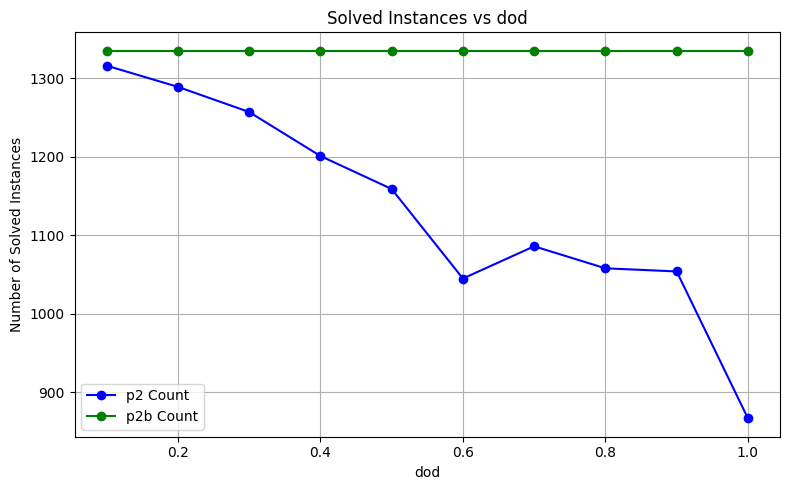

In [35]:

import matplotlib.pyplot as plt

# Group by discrete `dod` and count solved instances
count_p2 = p2_df_flex.groupby('dod').size().reset_index(name='count')
count_p2b = p2b_df_flex.groupby('dod').size().reset_index(name='count')

# Plot
plt.figure(figsize=(8, 5))
plt.plot(count_p2['dod'], count_p2['count'], label='p2 Count', marker='o', linestyle='-', color='blue')
plt.plot(count_p2b['dod'], count_p2b['count'], label='p2b Count', marker='o', linestyle='-', color='green')
plt.xlabel('dod')
plt.ylabel('Number of Solved Instances')
plt.title('Solved Instances vs dod')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
